In [1]:
from pathlib import Path
import itertools
from matplotlib import pyplot as plt
import pandas as pd
import re
from nimstim import create_csv
import numpy as np
from protosc.feature_matrix import FeatureMatrix
from protosc.filter_model import select_with_filter
from protosc.preprocessing import GreyScale, ViolaJones, CutCircle
from protosc.pipe_complex import PipeComplex
from protosc.feature_extraction import FourierFeatures, HOGFeatures
from protosc.io import ReadImage

In [2]:
# Set path to folder with faces: stim_data_dir
stim_data_dir = Path("..", "data", "Nimstim faces")

In [3]:
# Create overview of all images with their corresponding sex, emotion and mouth positioning
overview = create_csv(stim_data_dir)
# overview = overview.iloc[:50]

In [4]:
# Define pipeline
pipe1 = ReadImage()*ViolaJones(20)*CutCircle()*FourierFeatures()
pipe2 = ReadImage()*GreyScale()*ViolaJones(20)*CutCircle()*FourierFeatures()
pipe3 = ReadImage()*ViolaJones()*HOGFeatures()
pipe_complex = pipe1 + pipe2 + pipe3

In [5]:
def select_y(df, **kwargs):
    selected = np.ones(len(df), dtype=int)
    for col, val in kwargs.items():
        selected *= (df[col].values == val).astype(int)
    return selected

In [6]:
files = overview['file'].values
y = select_y(overview, mouth="open")
feature_res = pipe_complex.execute(files)

In [7]:
X = FeatureMatrix.from_pipe_data(feature_res)

In [8]:
np.random.seed(1928794)
filter_res = select_with_filter(X, y, fold_seed=1928742)

100%|██████████| 101/101 [40:06<00:00, 23.83s/it]  


ReadImage+ViolaJones+CutCircle+FourierFeatures


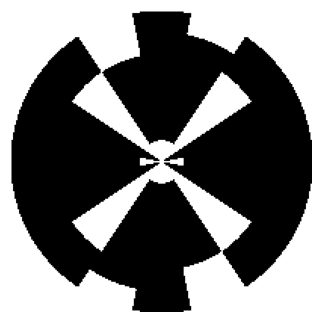

ReadImage+GreyScale+ViolaJones+CutCircle+FourierFeatures


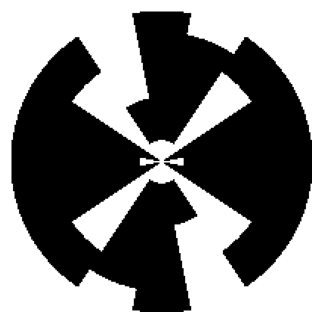

ReadImage+ViolaJones+HOGFeatures


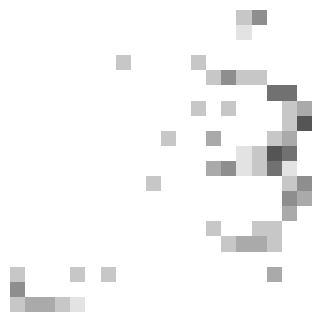

In [9]:
X.plot(filter_res)